In [58]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tqdm import tqdm

# For reproducibility
np.random.seed(42)

In [63]:
# Function to calculate MACD
def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    histogram = macd - signal
    return macd, signal, histogram

# Hill Climbing Algorithm
def hill_climbing(macd, signal, initial_delta1=0, initial_delta2=0, max_iter=100):
    delta1, delta2 = initial_delta1, initial_delta2
    best_profit = -np.inf
    
    for _ in range(max_iter):
        candidate_deltas = [(delta1 + np.random.randn(), delta2 + np.random.randn()) for _ in range(10)]
        profits = []
        
        for d1, d2 in candidate_deltas:
            actions = generate_actions(macd, signal, d1, d2)
            profit = calculate_profit(actions)
            profits.append((profit, d1, d2))
        
        best_candidate = max(profits, key=lambda x: x[0])
        if best_candidate[0] > best_profit:
            best_profit, delta1, delta2 = best_candidate
        else:
            break
    
    return delta1, delta2

# Function to generate actions
def generate_actions(macd, signal, delta1, delta2):
    actions = []
    for i in range(1, len(macd)):
        if macd[i] - signal[i] > delta1:
            actions.append(1)  # Buy
        elif signal[i] - macd[i] > delta2:
            actions.append(-1)  # Sell
        else:
            actions.append(0)  # Hold
    return actions

# Calculate Profit
def calculate_profit(actions):
    profit = 0
    position = 0  # 1 for holding a stock, 0 for not holding
    buy_price = 0
    for i, action in enumerate(actions):
        current_price = data['Close'].iloc[i]  # Assuming data is a global variable with 'Close' prices
        if action == 1 and position == 0:
            position = 1  # Buy
            buy_price = current_price
        elif action == -1 and position == 1:
            position = 0  # Sell
            profit += current_price - buy_price
    return profit

# GRU Model
def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))  # Output layer for Buy, Sell, Hold
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Prepare Data
def prepare_data(data, window_size=5):
    macd, signal, _ = calculate_macd(data['Close'])
    data['MACD'] = macd
    data['Signal'] = signal
    data = data.dropna()

    actions = generate_actions(macd, signal, 0, 0)
    
    features = []
    labels = []
    for i in range(window_size, len(data)):
        features.append(data[['MACD', 'Signal', 'Close']].iloc[i-window_size:i].values)
        action = actions[i-1]
        # Encode actions as 0, 1, 2
        if action == 1:
            labels.append(2)  # Buy
        elif action == -1:
            labels.append(1)  # Sell
        else:
            labels.append(0)  # Hold
    
    features = np.array(features)
    labels = np.array(labels)
    
    return features, labels



In [61]:
# Load your stock data here
data = pd.read_csv('D:\Stock Predicton\Datasets\MSFT.csv')

In [64]:
# Prepare data
features, labels = prepare_data(data)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)


In [65]:
# Convert labels to categorical
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)


In [66]:
# Build and train model
model = build_gru_model((X_train.shape[1], X_train.shape[2]))
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


c:\Users\g6kan\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.4191 - loss: 0.9080 - val_accuracy: 0.5249 - val_loss: 0.6975
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5020 - loss: 0.7211 - val_accuracy: 0.4975 - val_loss: 0.6965
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4980 - loss: 0.7045 - val_accuracy: 0.4851 - val_loss: 0.7033
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5389 - loss: 0.7002 - val_accuracy: 0.4826 - val_loss: 0.6994
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5282 - loss: 0.7052 - val_accuracy: 0.5721 - val_loss: 0.6812
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5477 - loss: 0.6940 - val_accuracy: 0.5697 - val_loss: 0.6752
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5965 - loss: 0.6750 - val_accuracy: 0.5522 - val_loss: 0.6765
Epoch 8/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5951 - loss: 0.6649 - val_accuracy: 0.6567 - val_loss

In [67]:


# Evaluate model
model.evaluate(X_test, y_test)



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9336 - loss: 0.1760 


[0.2081800401210785, 0.9184890389442444]

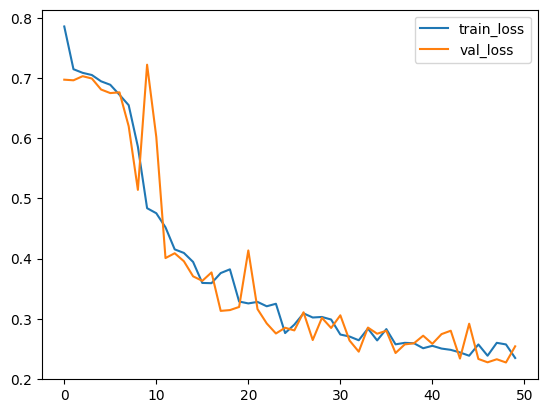

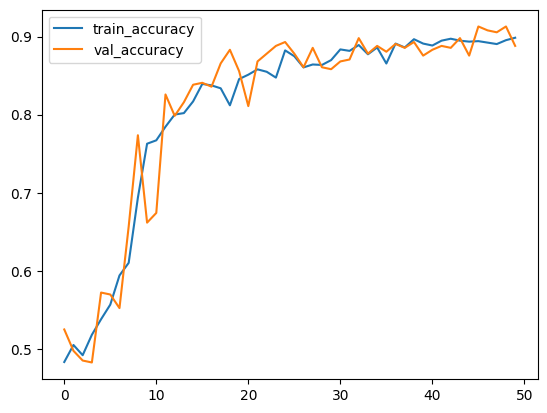

In [68]:
# Visualization
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()


In [69]:

# Predict and Simulate Trading
predictions = model.predict(X_test)
predicted_actions = np.argmax(predictions, axis=1)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


In [76]:
print(predicted_actions)
predicted_actions.shape

[2 1 2 1 1 1 2 2 1 2 1 1 2 1 1 2 2 2 2 2 2 1 1 2 2 2 2 1 2 2 1 1 2 2 1 1 2
 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 1 2 1 1 2 2 2 2 1 2 2 1 1 2 1 2 1 2 1 2 1 1
 1 1 2 1 2 2 2 1 1 2 1 1 1 2 1 1 2 1 1 1 1 2 2 2 2 1 2 2 1 2 2 1 1 2 1 1 2
 1 1 2 2 1 1 1 2 2 1 1 2 1 1 2 2 1 1 2 1 2 2 2 2 2 2 1 1 2 2 2 1 2 2 2 2 1
 2 2 1 1 1 2 2 1 1 2 1 1 2 1 1 2 2 1 1 1 1 1 1 1 2 1 1 1 1 1 2 2 1 2 1 1 2
 2 2 1 2 1 1 2 1 1 1 1 2 2 2 2 2 1 2 1 2 1 1 2 2 1 2 2 2 1 1 2 1 1 2 1 1 2
 2 2 1 2 2 2 2 1 1 2 2 2 2 2 1 2 2 2 1 2 1 1 2 1 2 2 2 1 1 1 2 1 2 2 1 2 1
 1 2 2 2 1 2 1 1 2 1 2 2 2 2 2 1 2 2 1 2 1 1 2 1 2 2 2 2 2 2 1 1 2 1 1 2 2
 1 2 2 1 2 2 1 2 1 1 2 2 1 2 1 1 1 1 1 1 2 2 1 2 2 2 2 2 2 1 2 1 1 2 1 2 2
 2 2 1 1 1 2 1 1 2 2 2 1 2 1 1 1 2 2 1 2 2 1 2 1 2 2 2 1 2 2 2 1 1 2 2 1 2
 1 2 2 1 2 2 2 2 1 2 1 1 2 2 2 2 2 2 2 2 2 1 1 2 1 1 2 2 1 2 1 1 1 1 1 2 1
 1 1 2 2 2 2 2 1 2 2 2 2 1 1 1 2 1 2 1 1 2 1 1 2 1 1 2 2 1 1 1 2 1 2 2 1 1
 1 2 1 2 1 2 2 2 1 2 1 1 1 2 1 1 2 1 2 1 1 2 2 2 2 2 2 1 1 2 1 2 2 1 2 1 2
 1 1 1 1 1 2 1 1 1 1 2 1 

(503,)

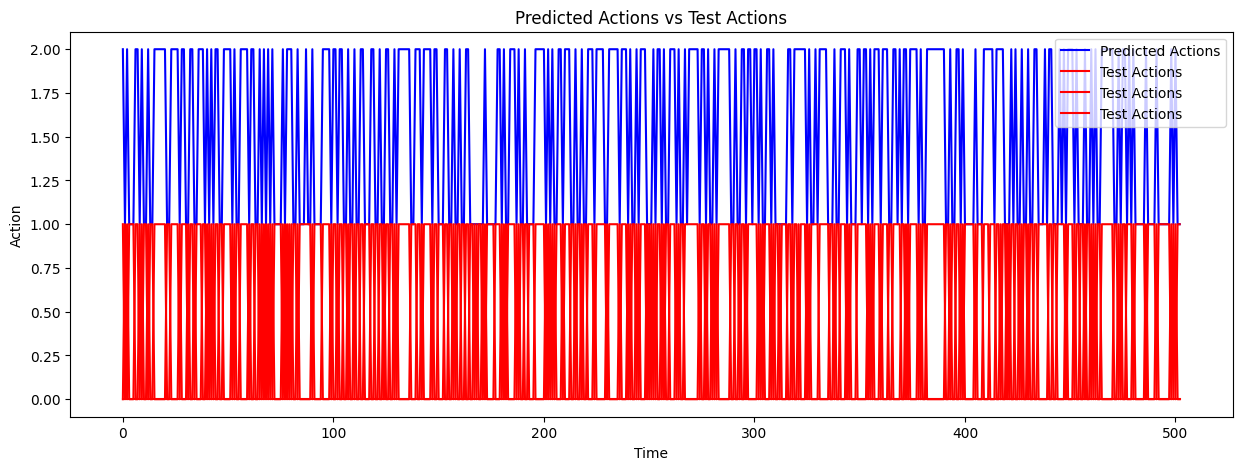

In [74]:
# Plot predicted actions and test actions
plt.figure(figsize=(15, 5))
plt.plot(predicted_actions, label='Predicted Actions', color='blue')
plt.plot(y_test, label='Test Actions', color='red')
plt.xlabel('Time')
plt.ylabel('Action')
plt.title('Predicted Actions vs Test Actions')
plt.legend()
plt.show()

In [82]:
# Plot predicted actions on closing price chart


predicted_actions = predicted_actions[:100]
closing_prices = data['Close'].values[-len(predicted_actions):]
buy_signals = np.where(predicted_actions == 2)[0]
sell_signals = np.where(predicted_actions == 1)[0]
hold_signals = np.where(predicted_actions == 0)[0]

print(buy_signals.shape)
print(sell_signals.shape)
print(hold_signals.shape)

(53,)
(47,)
(0,)


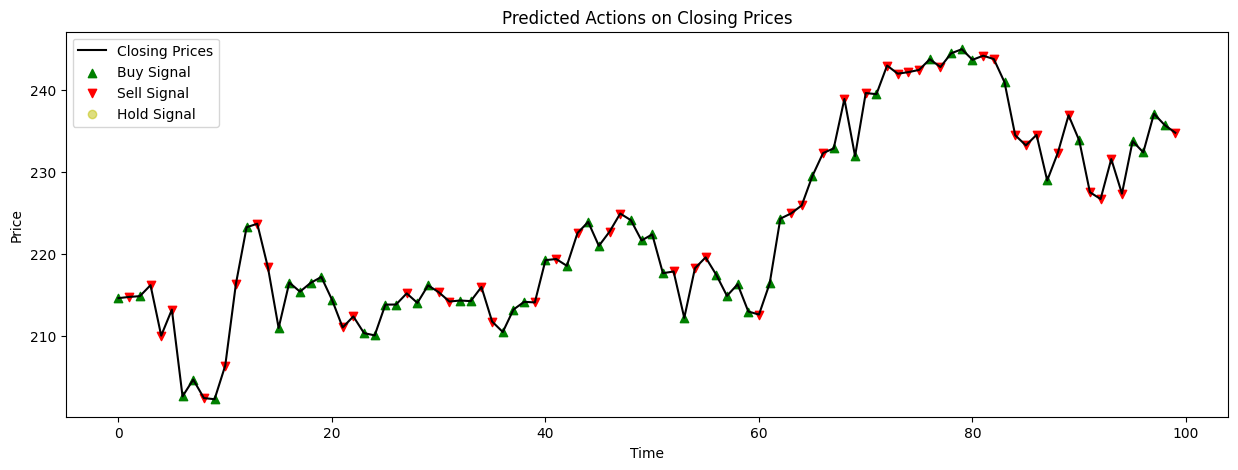

In [83]:
plt.figure(figsize=(15, 5))
plt.plot(closing_prices, label='Closing Prices', color='black')

plt.scatter(buy_signals, closing_prices[buy_signals], marker='^', color='g', label='Buy Signal', alpha=1)
plt.scatter(sell_signals, closing_prices[sell_signals], marker='v', color='r', label='Sell Signal', alpha=1)
plt.scatter(hold_signals, closing_prices[hold_signals], marker='o', color='y', label='Hold Signal', alpha=0.5)

plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Predicted Actions on Closing Prices')
plt.legend()
plt.show()

In [70]:
# Simulate trading based on predicted actions
profits = calculate_profit(predicted_actions)
print(f'Total Profit: {profits}')

Total Profit: 0
